# Analysis of experiments
Date: 22-01-2024

Goals are to
- [DONE] visualize the evolution of the energy consumption of the server and the clients during the training
- [DONE] visualize the evolution of the local and global loss/accuracy
- Compare the evolutions accross experiments
- Compute the local/total energy consumption of each experiments
- Compute the energy consumption of each round for each clients
- is the energy consumed by each round stable? How does the number of epoch impacts it?

Remarks:
- Power is in milliwatts

## Imports and paths

In [4]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import glob
import time
import datetime
from read_result import EnergyResult

In [2]:
result_folder = "./results/outputs_from_tl/"

## Get Hyperparameters

{'params': {'num_classes': 10,
  'num_rounds': 3,
  'num_clients': 1,
  'batch_size': 128,
  'validation_split': 10,
  'num_clients_per_round_fit': 2,
  'num_clients_per_round_eval': 2,
  'root_data': '${hydra:runtime.cwd}/data'},
 'client': {'lr': 0.1,
  'local_epochs': 5,
  'cid': 0,
  'dry_run': False,
  'decay_rate': 0.1,
  'decay_steps': 10},
 'comm': {'host': '172.16.121.1', 'port': 8080},
 'defaults': [{'neuralnet': 'MobileNetV3Small'},
  {'strategy': 'fedavg'},
  {'optimizer': 'SGD'},
  '_self_'],
 'hydra': {'run': {'dir': './outputs/${hydra.job.name}_${client.cid}/${now:%Y-%m-%d}/${now:%H-%M-%S}'}}}

In [11]:
yaml_df.defaults[0][0]

{'neuralnet': 'MobileNetV3Small'}

## Visualisation of raw csvs

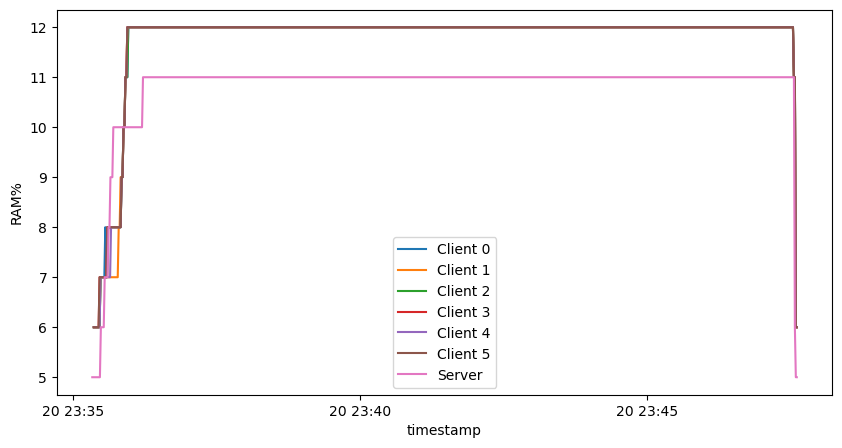

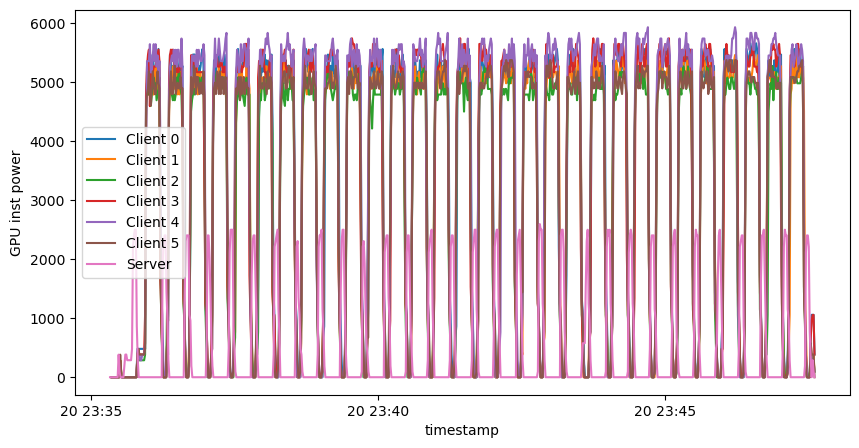

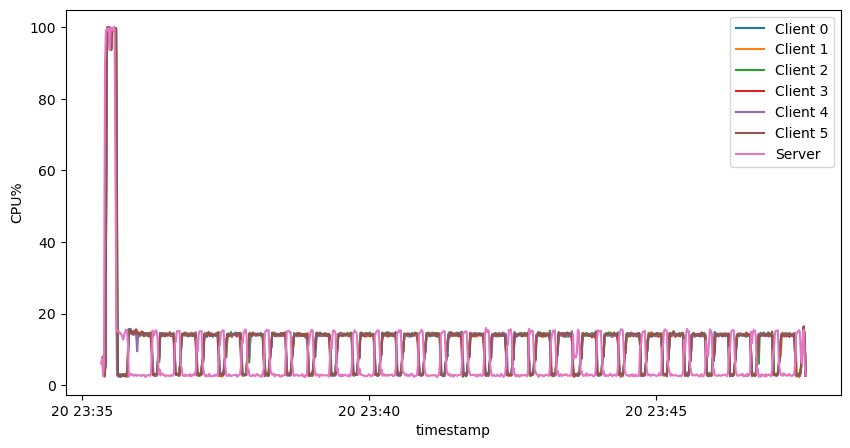

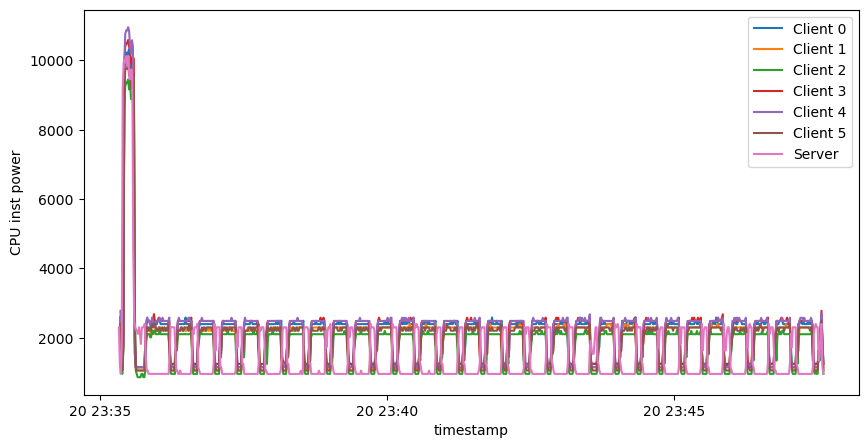

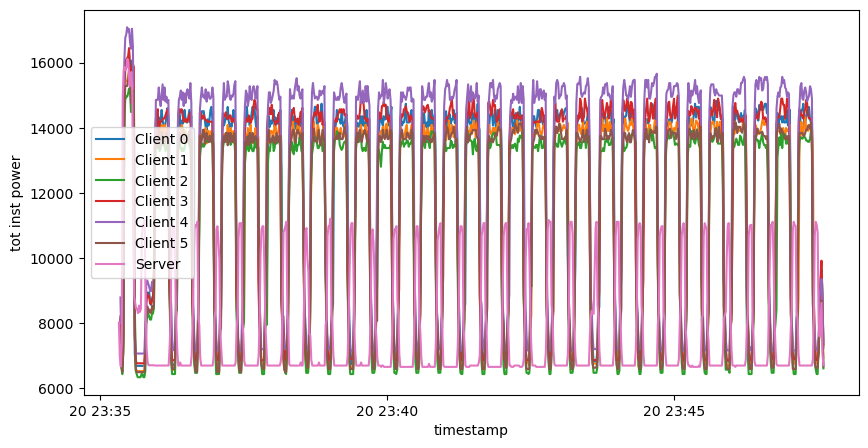

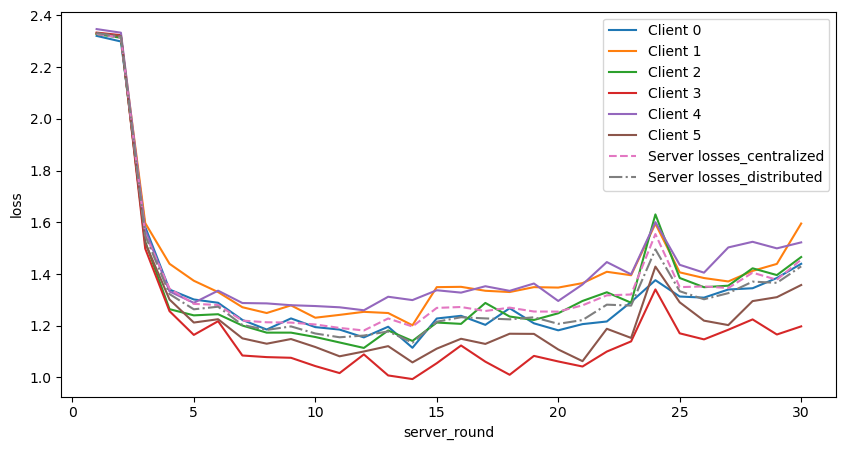

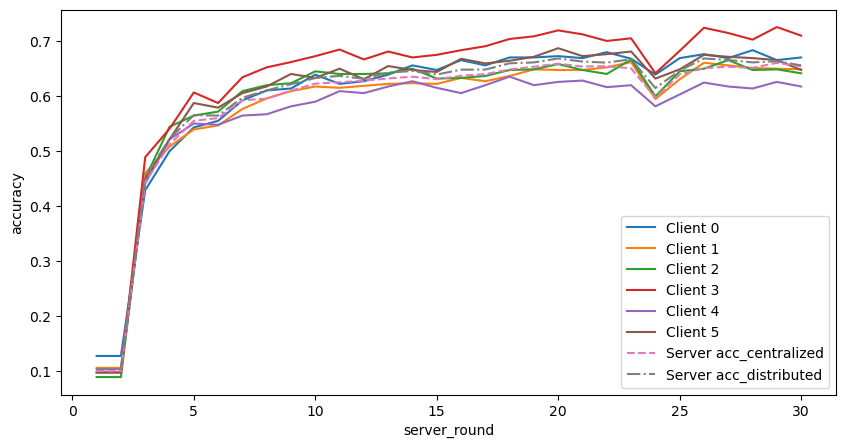

In [69]:
result_plot = {"loss": ["results","server_round","loss","losses_centralized","losses_distributed"],
                    "accuracy": ["results","server_round","accuracy","acc_centralized","acc_distributed"]}
        
            
result = EnergyResult(result_folder, 6, "2024-01-20","23-35-20","23-35-19")
mycsv = result._read_client(5)
server = result._read_server()
result.make_energy_plot("energy",'timestamp',"RAM%")
result.make_energy_plot("energy",'timestamp',"GPU inst power")
result.make_energy_plot("energy",'timestamp',"CPU%")
result.make_energy_plot("energy",'timestamp',"CPU inst power")
result.make_energy_plot("energy",'timestamp',"tot inst power")
result.make_result_plot(**result_plot)

## Measuring energy

In [74]:
energy = pd.read_csv(result_folder+"client_0/2024-01-20/23-35-20/energy.csv", parse_dates=["timestamp"])
energy.columns = [col.strip() for col in energy.columns]
        

In [85]:
def convert_timestamp_to_sec(timestamp, pattern="%Y-%m-%d %H:%M:%S.%f"):
    """Return timestamp in seconds.
    
    examples of pattern:
    "%Y/%m/%d %H:%M:%S.%f"
    "%Y-%m-%dT%H:%M:%S+01:00"
    "%Y-%m-%dT%H:%M:%S.%f+02:00"
    "%Y-%m-%d %I:%M:%S %p"
    """
    return time.mktime(
        datetime.datetime.strptime(
            timestamp, 
            pattern
            ).timetuple())

In [14]:
def compute_energy(energy):
    """Compute energy in kWh and J.
    
    Return energy in kWh and J.    
    """
    energy_mWs = (energy["timestamp"].diff().dt.total_seconds()*energy["tot inst power"]).sum()
    energy_kWh = energy_mWs/1000/3600/1000
    energy_J = energy_mWs/1000
    return energy_kWh, energy_J

In [122]:
for client_id in range(0,6):
    energy = pd.read_csv(result_folder+f"client_{client_id}/2024-01-20/23-35-20/energy.csv", parse_dates=["timestamp"])
    energy.columns = [col.strip() for col in energy.columns]
    energy_kWh, energy_J = compute_energy(energy)
    print(f"client {client_id}: {energy_kWh} kWh, {energy_J} J")

client 0: 0.0024209565839430555 kWh, 8715.443702195 J
client 1: 0.0023585737131769442 kWh, 8490.865367437 J
client 2: 0.002282889252480833 kWh, 8218.401308931 J
client 3: 0.002420358146009444 kWh, 8713.289325634 J
client 4: 0.0025504876060691664 kWh, 9181.755381849 J
client 5: 0.002332982828994722 kWh, 8398.738184381 J


In [124]:
energy = pd.read_csv(result_folder+f"main_server_0/2024-01-20/23-35-19/energy.csv", parse_dates=["timestamp"])
energy.columns = [col.strip() for col in energy.columns]
energy_kWh, energy_J = compute_energy(energy)
print(f"server: {energy_kWh} kWh, {energy_J} J")

server: 0.0015934752078311113 kWh, 5736.510748192 J


## Studying energy per rounds

In [32]:
result = EnergyResult(result_folder, 6, "2024-01-20","22-40-32","22-40-25")
clients = result._read_all_clients()
server = result._read_server()

In [33]:
styled_df = clients[5].energy[["timestamp", "tot inst power"]].head(10).style.background_gradient(cmap='Blues', subset=['tot inst power'])
styled_df

,timestamp,tot inst power
0,2024-01-20 22:40:33.368284,8031
1,2024-01-20 22:40:34.339464,6690
2,2024-01-20 22:40:35.339331,6498
3,2024-01-20 22:40:36.353051,7361
4,2024-01-20 22:40:37.364970,14525
5,2024-01-20 22:40:38.372670,15188
6,2024-01-20 22:40:39.368352,15285
7,2024-01-20 22:40:40.370749,15325
8,2024-01-20 22:40:41.379587,15476
9,2024-01-20 22:40:42.370047,15636


In [34]:
clients[5].fittimes.head(10)

,Client ID,Server Round,Start Time,End Time,fittime
0,5,1,2024-01-20 22:40:55,2024-01-20 22:41:23,28.0
1,5,2,2024-01-20 22:41:34,2024-01-20 22:41:58,24.0
2,5,3,2024-01-20 22:42:14,2024-01-20 22:42:33,19.0
3,5,4,2024-01-20 22:42:44,2024-01-20 22:43:03,19.0
4,5,5,2024-01-20 22:43:13,2024-01-20 22:43:33,20.0
5,5,6,2024-01-20 22:43:46,2024-01-20 22:44:06,20.0
6,5,7,2024-01-20 22:44:16,2024-01-20 22:44:36,20.0
7,5,8,2024-01-20 22:44:45,2024-01-20 22:45:05,20.0
8,5,9,2024-01-20 22:45:14,2024-01-20 22:45:34,20.0
9,5,10,2024-01-20 22:45:44,2024-01-20 22:46:03,19.0


In [35]:
for client_id in range(6):
    for round_id in range(len(clients[client_id].fittimes)):
        start_time, end_time = clients[client_id].fittimes.at[round_id,"Start Time"], clients[client_id].fittimes.at[round_id,"End Time"]
        energy_df = clients[client_id].energy[(clients[client_id].energy["timestamp"]>=start_time) & (clients[client_id].energy["timestamp"]<=end_time)]
        energy_kWh, energy_J = compute_energy(energy_df)
        clients[client_id].fittimes.at[round_id,"energy_kWh"] = energy_kWh
        clients[client_id].fittimes.at[round_id,"energy_J"] = energy_J

In [36]:
clients[client_id].fittimes.style.background_gradient(cmap='plasma', subset=['energy_J'])

,Client ID,Server Round,Start Time,End Time,fittime,energy_kWh,energy_J
0,5,1,2024-01-20 22:40:55,2024-01-20 22:41:23,28.000000,0.000105,377.978695
1,5,2,2024-01-20 22:41:34,2024-01-20 22:41:58,24.000000,0.000096,346.762496
2,5,3,2024-01-20 22:42:14,2024-01-20 22:42:33,19.000000,0.000083,300.077939
3,5,4,2024-01-20 22:42:44,2024-01-20 22:43:03,19.000000,0.000084,304.135106
4,5,5,2024-01-20 22:43:13,2024-01-20 22:43:33,20.000000,0.000087,312.627441
5,5,6,2024-01-20 22:43:46,2024-01-20 22:44:06,20.000000,0.000086,309.697191
6,5,7,2024-01-20 22:44:16,2024-01-20 22:44:36,20.000000,0.000087,312.180015
7,5,8,2024-01-20 22:44:45,2024-01-20 22:45:05,20.000000,0.000088,315.868189
8,5,9,2024-01-20 22:45:14,2024-01-20 22:45:34,20.000000,0.000088,317.257057
9,5,10,2024-01-20 22:45:44,2024-01-20 22:46:03,19.000000,0.000085,306.259591


In [39]:
clients[client_id].fittimes["energy_kWh"].agg(["sum","mean","std"])

sum     0.001749
mean    0.000087
std     0.000005
Name: energy_kWh, dtype: float64

In [37]:
energy_df.style.background_gradient(cmap='viridis', subset=['tot inst power'])

,timestamp,RAM%,GPU%,GPU inst power,GPU avg power,CPU%,CPU inst power,CPU avg power,tot inst power,tot avg power
604,2024-01-20 22:50:37.666905,12,0.000000,1057,907,4.620000,1537,1549,8369,8181
605,2024-01-20 22:50:38.669930,12,99.200000,6609,3758,13.250000,2202,1875,15771,11974
606,2024-01-20 22:50:39.672279,12,0.000000,7845,5801,12.750000,2200,2037,17193,14582
607,2024-01-20 22:50:40.671363,12,30.600000,7750,6775,12.870000,2200,2118,17136,15857
608,2024-01-20 22:50:41.671913,12,98.600000,7659,7217,12.500000,2296,2207,17238,16547
609,2024-01-20 22:50:42.672720,12,0.000000,8131,7673,12.750000,2200,2203,17749,17147
610,2024-01-20 22:50:43.671952,12,55.300000,7659,7666,12.370000,2200,2201,17047,17095
611,2024-01-20 22:50:44.672491,12,0.000000,8131,7898,12.500000,2200,2200,17709,17400
612,2024-01-20 22:50:45.672695,12,54.000000,7659,7779,12.620000,2200,2200,17047,17223
613,2024-01-20 22:50:46.672632,12,98.500000,7654,7716,12.250000,2296,2248,17136,17178
